In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import torchvision.datasets as datasets
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader

import seaborn as sns

import sys
sys.path.append('./python_files/')
import pickle

from model_trainer import ModelTrainer
from utils import *
from data_loader import *
from nn_modules import View
from nn_models import *

In [2]:
print("pytorch version: ",torch.__version__)

pytorch version:  1.0.0


In [3]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("Using GPU: ",torch.cuda.get_device_name(0))

Using GPU:  GeForce GTX 1080 Ti


## 0) Loading the data (MNIST or CIFAR-10)

In [68]:
CIFAR = True

In [69]:
train_input_full, train_target_full, test_input_full, test_target_full = load_data(cifar=CIFAR, normalize=True, flatten=False, full=True)

train_target_full = train_target_full.long()
test_target_full = test_target_full.long()

* Using CIFAR
Files already downloaded and verified
Files already downloaded and verified
** Use 50000 train and 10000 test samples


In [70]:
print("shape of training samples :", train_input_full.shape)

shape of training samples : torch.Size([50000, 3, 32, 32])


In [71]:
nb_sample = 60000
train_input = train_input_full[0:nb_sample]
train_target = train_target_full[0:nb_sample]

test_input = test_input_full[0:nb_sample]
test_target = test_target_full[0:nb_sample]

In [72]:
print("shape of training samples :", train_input.shape)
print("shape of testing samples :", test_input.shape)

shape of training samples : torch.Size([50000, 3, 32, 32])
shape of testing samples : torch.Size([10000, 3, 32, 32])


In [73]:
computeClassesWeights(train_target)

tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000])

In [74]:
computeClassesWeights(test_target)

tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000])

## 1) LeNet with disjoint trainset and testset (train 10 shadow models)

In [75]:
train_dataset = (train_input, train_target)
test_dataset = (test_input, test_target)

In [76]:
crossEntropyClassesWeigths = computeClassesWeights(train_target)

In [77]:
load_from_memory = True

In [78]:
size_input_vector = train_dataset[0].shape

In [79]:
if not load_from_memory:
    shadow_models = list()
    nb_shadow_models = 100

    (shadow_train_datasets, shadow_test_datasets) = \
        generate_n_shadow_models_datasets(nb_shadow_models, train_dataset, test_dataset)

    for i in range(nb_shadow_models):
        print("training model", i)
        shadow_models.append(shadow_model(size_input_vector) if CIFAR else AlmostLeNet())

        crit_fun = lambda input_, target : (input_, target)
        y_hat_fun = lambda y: y.argmax(1)

        loss_fun = nn.CrossEntropyLoss()
        learning_rate = 0.1

        mt = ModelTrainer(shadow_models[i], loss_fun, optim.SGD(shadow_models[i].parameters(), lr=learning_rate), y_hat_fun, crit_fun)
        hist = mt.fit(shadow_train_datasets[i], shadow_test_datasets[i], epochs=300, batch_size=500, verbose=0)
        #mt.plot_training("Learning curves")

In [80]:
if CIFAR:
    path = 'shadow_models_cifar/shadow_model_'
else:
    path = 'shadow_models/shadow_model_'

if not load_from_memory:
    for i in range(nb_shadow_models):
        
        save_model_state(shadow_models[i], path+str(i)+'_F.pickle')

In [82]:
if load_from_memory:
        
    shadow_models = list()
    nb_shadow_models = 100

    (shadow_train_datasets, shadow_test_datasets) = \
        generate_n_shadow_models_datasets(nb_shadow_models, train_dataset, test_dataset)
    
    for i in range(nb_shadow_models):
        shadow_models.append(shadow_model(size_input_vector) if CIFAR else AlmostLeNet())
        
    for i in range(nb_shadow_models):
        load_model_state(shadow_models[i], path+str(i)+'_F.pickle')

In [83]:
shadow_train_datasets[0][0].shape

torch.Size([500, 3, 32, 32])

## 2) Train G with shadow models (Dense layers)

In [84]:
for i in range(nb_shadow_models):
    shadow_models[i].eval()

In [85]:
shadow_models[0]

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Dropout(p=0.25)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (9): ReLU()
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Dropout(p=0.25)
  (12): View(_, [-1])
  (13): Linear(in_features=2304, out_features=512, bias=True)
  (14): ReLU()
  (15): Dropout(p=0.5)
  (16): Linear(in_features=512, out_features=10, bias=True)
)

In [86]:
layers = list()
layer_names = list()

for i in range(nb_shadow_models):
    layers.append(shadow_models[i][16])
    layer_names.append("shadow_model["+str(i)+"].view")

In [87]:
layers[5]

Linear(in_features=512, out_features=10, bias=True)

In [88]:
g_shadow_train_datasets, g_shadow_test_datasets = \
generate_dataset_g_per_class_from_shadows(shadow_models, shadow_train_datasets, shadow_test_datasets, layers, layer_names, split=0.8, nb_class=10)

In [89]:
g_shadow_test_datasets[0][1].shape

torch.Size([1284])

In [90]:
choosen_class = 0
g_shadow_train_dataset = g_shadow_train_datasets[choosen_class]
g_shadow_test_dataset = g_shadow_test_datasets[choosen_class]

g_shadow_train_dataset, g_shadow_test_dataset = normalize_data(g_shadow_train_dataset, g_shadow_test_dataset)

In [91]:
size_input_vector = g_shadow_train_dataset[0].shape
print("size of layer vector :", size_input_vector)
flattened_size = np.prod(np.array(g_shadow_train_dataset[0].shape[1:]))
print("size of flattened input (1 sample):", flattened_size)

size of layer vector : torch.Size([4716, 1, 10])
size of flattened input (1 sample): 10


In [92]:
g_shadow_target_weigths = torch.abs(1-computeClassesWeights(g_shadow_train_dataset[1]))
g_shadow_target_weigths# = torch.Tensor([0.90, 0.1])

tensor([0.8393, 0.1607])

In [93]:
def denseG(vector_size):
    model = nn.Sequential(
        View([-1]),
        nn.Linear(vector_size, 256),
        nn.ReLU(),
        nn.BatchNorm1d(256),
        nn.Dropout(0.5),

        nn.Linear(256, 128),
        nn.ReLU(),
        nn.BatchNorm1d(128),
        nn.Dropout(0.5),
        
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.BatchNorm1d(64),
        nn.Dropout(0.3),
        
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.BatchNorm1d(32),
        
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.BatchNorm1d(16),
        
        nn.Linear(16, 2),
        nn.Softmax(1)
    )
    return model

def small_denseG(vector_size):
    model = nn.Sequential(
        View([-1]),
        nn.Linear(vector_size, 2),
        nn.ReLU(),
        nn.BatchNorm1d(2),
        
        nn.Linear(2, 2),
    )
    return model

In [94]:
sufix = "denseG_CIFAR_output"

In [100]:
model = denseG(flattened_size)
sum(x.numel() for x in model.parameters())

47602

CRITICAL:root:Cannot load caffe2.python. Error: /opt/pytorch/pytorch/torch/lib/python3.6/site-packages/caffe2/python/caffe2_pybind11_state.cpython-36m-x86_64-linux-gnu.so: undefined symbol: _ZN5fLI6438FLAGS_caffe2_max_keep_on_shrink_memoryE


******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                    0.71219493           0.488      0.69657207           0.500
100                  0.48886461           0.817      0.46839935           0.842
200                  0.47537780           0.831      0.46182594           0.848
300                  0.46364392           0.843      0.46344140           0.851
400                  0.46045567           0.848      0.46461162           0.848
500                  0.45615405           0.853      0.46561208           0.847
600                  0.45400609           0.856      0.46456066           0.846
700                  0.45036026           0.862      0.46250013           0.849
800                  0.44899956           0.861      0.46432322           0.849
900                  0.44958518           0.863      0.46325609           0.852
1000                 0.44624971         

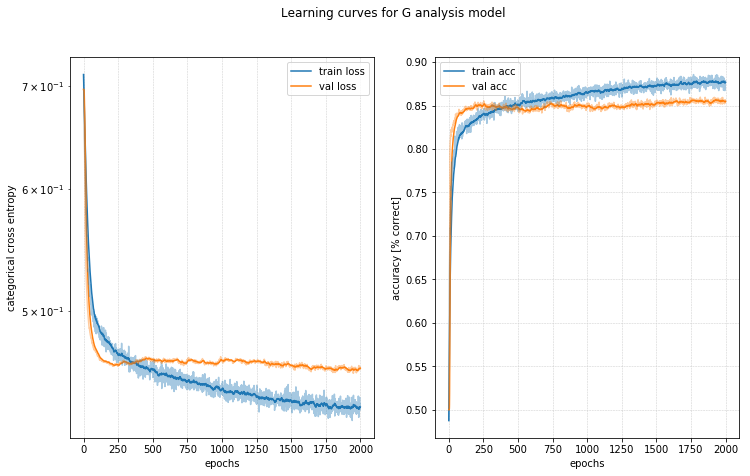

In [101]:
shadow_modelG = denseG(flattened_size)

crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)

loss_fun = nn.CrossEntropyLoss(g_shadow_target_weigths)
learning_rate = 0.05
epochs = 2000

mt = ModelTrainer(shadow_modelG, loss_fun, optim.SGD(shadow_modelG.parameters(), lr=learning_rate), y_hat_fun, crit_fun)
hist = mt.fit(g_shadow_train_dataset, g_shadow_test_dataset, epochs=epochs, batch_size=1000, verbose=epochs/20)
plotted = mt.plot_training("Learning curves for G analysis model")

In [104]:
#def backtest
with torch.no_grad():
    shadow_modelG.eval()
    g_shadow_test_dataset[1]

tensor([1, 1, 1,  ..., 0, 0, 0])

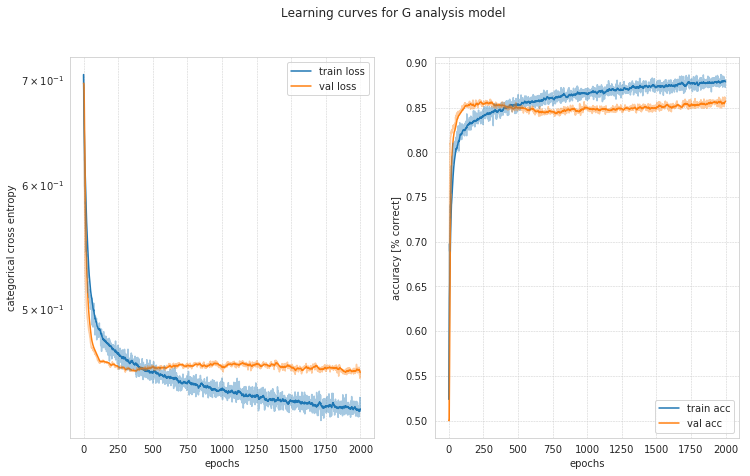

In [46]:
hist.plot("Learning curves for G analysis model")
plt.savefig("G_curve_" + sufix + ".png", dpi=300, bbox_inches='tight')

false negative percentage : 10.652591170825332
false positive percentage : 18.181818181818183


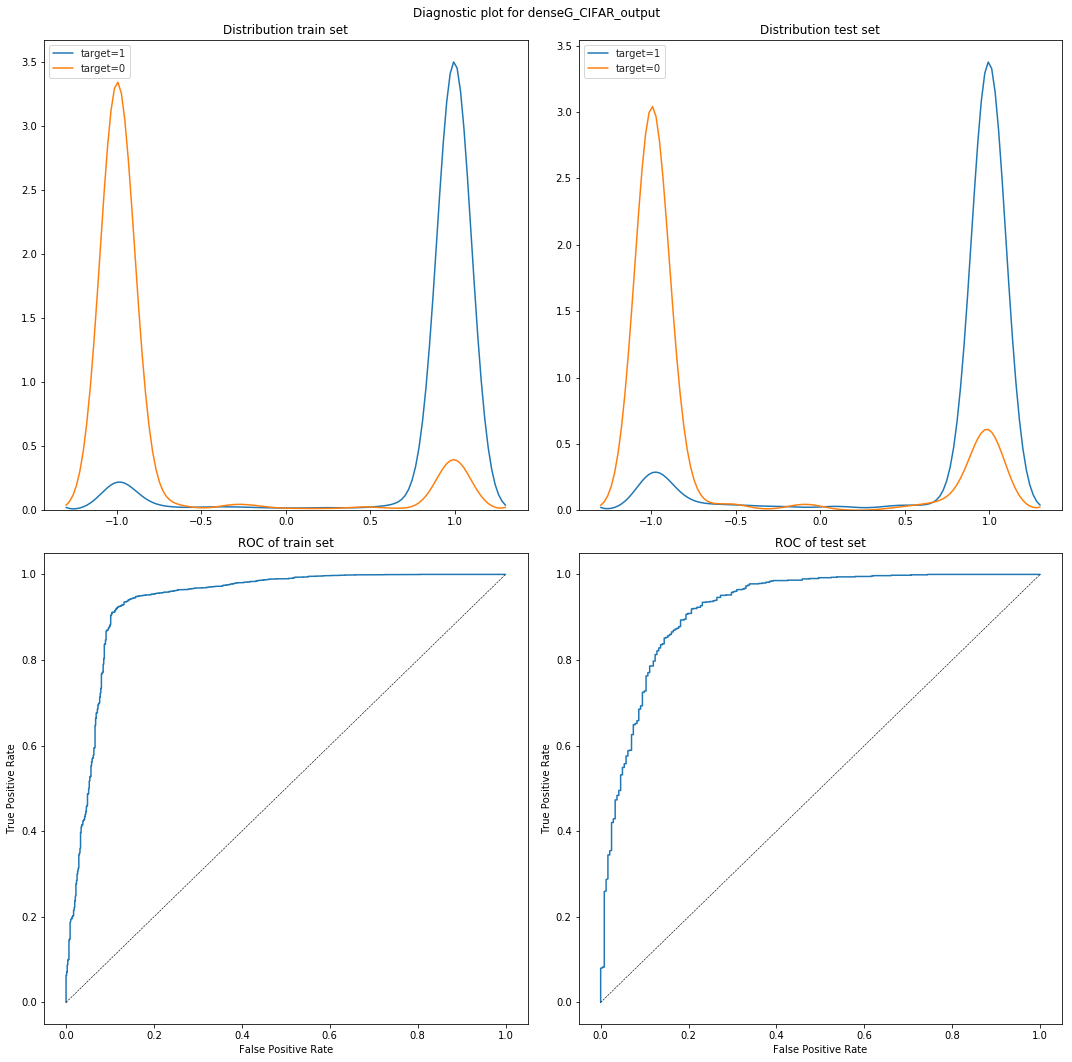


ROC score train : 0.9347134023340058
ROC score test : 0.9223699655779574


In [102]:
diagnostic_plots(shadow_modelG, [g_shadow_train_dataset], [g_shadow_test_dataset], bw=0.1, dataset_name=sufix,savefig=True)

## 3) Train G with shadow models (Conv layers)

In [29]:
for i in range(nb_shadow_models):
    shadow_models[i].eval()

In [30]:
shadow_models[0]

AlmostLeNet(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (mxp1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (view): View(_, [-1])
  (fc1): Linear(in_features=576, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

In [53]:
layers = list()
layer_names = list()

for i in range(nb_shadow_models):
    layers.append(shadow_models[i].fc2)
    layer_names.append("shadow_model["+str(i)+"].conv1")

In [54]:
g_shadow_train_datasets, g_shadow_test_datasets = \
generate_dataset_g_per_class_from_shadows(shadow_models, shadow_train_datasets, shadow_test_datasets, layers, layer_names, split=0.8, nb_class=10)

In [55]:
g_shadow_test_datasets[0][1].shape

torch.Size([1462])

In [56]:
choosen_class = 0
g_shadow_train_dataset = g_shadow_train_datasets[choosen_class]
g_shadow_test_dataset = g_shadow_test_datasets[choosen_class]

g_shadow_train_dataset, g_shadow_test_dataset = normalize_data(g_shadow_train_dataset, g_shadow_test_dataset)

In [57]:
g_shadow_train_dataset[0] = g_shadow_train_dataset[0].squeeze(1)
g_shadow_test_dataset[0] = g_shadow_test_dataset[0].squeeze(1)

In [58]:
size_input_vector = g_shadow_train_dataset[0].shape
print("size of layer vector :", size_input_vector)

size of layer vector : torch.Size([5441, 10])


In [59]:
g_shadow_target_weigths = torch.abs(1-computeClassesWeights(g_shadow_train_dataset[1]))
g_shadow_target_weigths# = torch.Tensor([0.90, 0.1])

tensor([0.8638, 0.1362])

In [60]:
def kindaResnetG(layer_dim):
    dim = layer_dim[2]
    pad = (1, 1, 1)
    pool = 4
    finalVectorSize = layer_dim[2]//pool * layer_dim[3]//pool * layer_dim[4]//pool
    print(finalVectorSize)
    model = nn.Sequential(
        nn.Conv3d(1, 1, kernel_size=3, padding = pad),
        nn.ReLU(),
        nn.BatchNorm3d(1),
        
        nn.Conv3d(1, 1, kernel_size=3, padding = pad),
        nn.ReLU(),
        nn.BatchNorm3d(1),
        
        nn.Conv3d(1, 1, kernel_size=3, padding = pad),
        nn.ReLU(),
        nn.BatchNorm3d(1),
        nn.MaxPool3d(pool),

        View([-1]),
        nn.Linear(finalVectorSize, 128),
        nn.ReLU(),
        #nn.Linear(64, 128),
        #nn.ReLU(),
        nn.Linear(128, 32),
        nn.ReLU(),
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Linear(16, 2),
        nn.Softmax(1)
    )
    return model

def VGG16ResnetBlock(layer_dim):
    dim0 = layer_dim[1]
    dim = 8
    pad = (1, 1)
    pool = 2
    finalVectorSize = 196#dim//pool * layer_dim[2]//pool * layer_dim[3]//pool
    print(finalVectorSize)
    model = nn.Sequential(
        nn.Conv2d(dim0, dim, kernel_size=3, padding = pad),
        nn.ReLU(),
        nn.BatchNorm2d(dim),
        
        nn.Conv2d(dim, dim, kernel_size=3, padding = pad),
        nn.ReLU(),
        nn.BatchNorm2d(dim),
        
        nn.Conv2d(dim, dim, kernel_size=3, padding = pad),
        nn.ReLU(),
        nn.BatchNorm2d(dim),
        
        nn.Conv2d(dim, dim, kernel_size=3, padding = pad),
        nn.ReLU(),
        nn.BatchNorm2d(dim),
        nn.MaxPool3d(pool),

        View([-1]),
        nn.Linear(finalVectorSize, 32),
        nn.ReLU(),
        nn.Linear(32, 32),
        nn.ReLU(),
        nn.Linear(32, 2)
    )
    return model

In [61]:
model = denseG(size_input_vector[1])
sum(x.numel() for x in model.parameters())

47602

CRITICAL:root:Cannot load caffe2.python. Error: /opt/pytorch/pytorch/torch/lib/python3.6/site-packages/caffe2/python/caffe2_pybind11_state.cpython-36m-x86_64-linux-gnu.so: undefined symbol: _ZN5fLI6438FLAGS_caffe2_max_keep_on_shrink_memoryE


******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                    0.69911873           0.501      0.68946844           0.500
30                   0.68830464           0.533      0.68916965           0.528
60                   0.68375445           0.556      0.68929702           0.542
90                   0.67769245           0.567      0.68721491           0.534
120                  0.67545375           0.569      0.68572730           0.544
150                  0.67574056           0.570      0.68561751           0.544
180                  0.67157094           0.578      0.68375158           0.552
210                  0.66613351           0.588      0.68208021           0.557
240                  0.66645083           0.590      0.68386233           0.558
270                  0.66362868           0.595      0.68564039           0.564
300                  0.65996275         

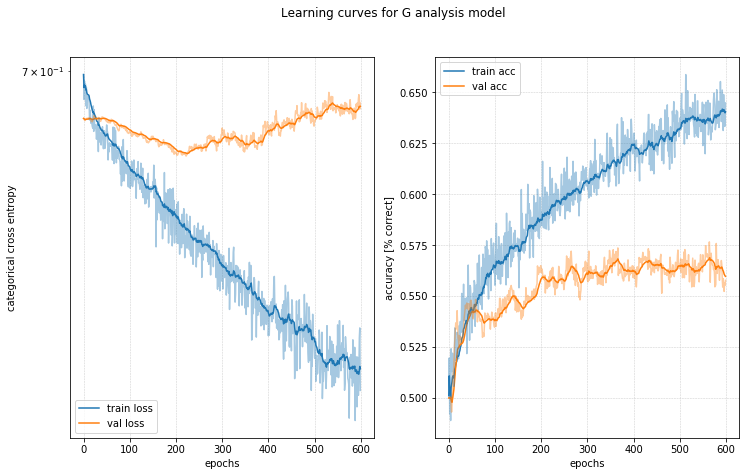

In [62]:
shadow_modelG = denseG(size_input_vector[1])

crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)

loss_fun = nn.CrossEntropyLoss(g_shadow_target_weigths)
learning_rate = 0.05 #0.005
epochs = 600

mt = ModelTrainer(shadow_modelG, loss_fun, optim.SGD(shadow_modelG.parameters(), lr=learning_rate), y_hat_fun, crit_fun)
hist = mt.fit(g_shadow_train_dataset, g_shadow_test_dataset, epochs=epochs, batch_size=1000, verbose=epochs/20)
mt.plot_training("Learning curves for G analysis model")

In [38]:
sufix = 'resnetblockG_CIFAR_layer6'

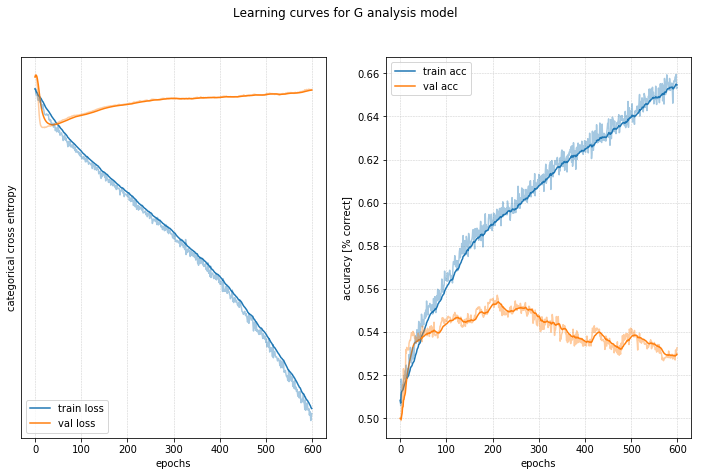

In [39]:
hist.plot("Learning curves for G analysis model")
plt.savefig("G_curve_" + sufix + ".png", dpi=300, bbox_inches='tight')

false negative percentage : 10.172744721689057
false positive percentage : 19.421487603305785


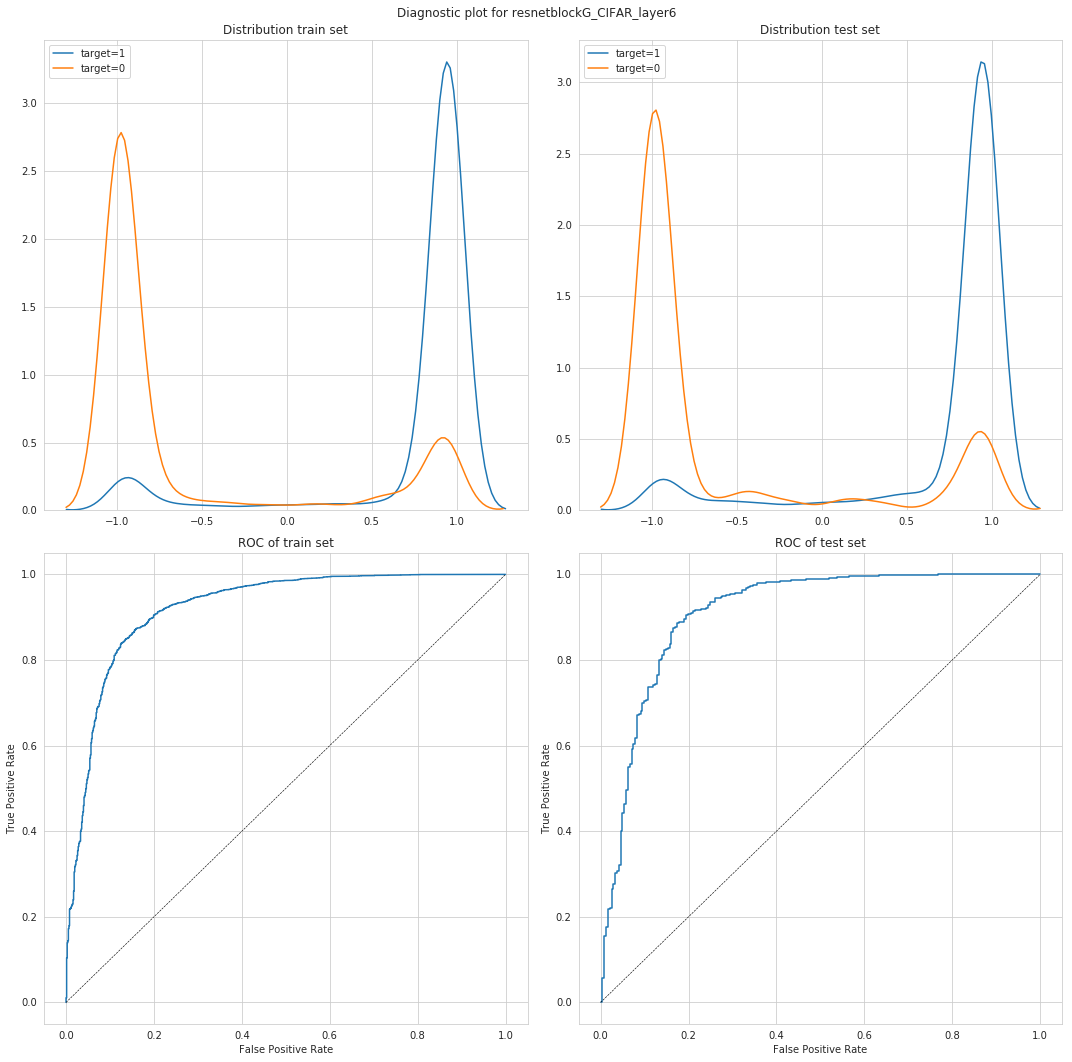


ROC score train : 0.9215086241952106
ROC score test : 0.9107842515188529


In [69]:
diagnostic_plots(shadow_modelG, [g_shadow_train_dataset], [g_shadow_test_dataset], dataset_name=sufix, bw=0.1, savefig=False)

## 4) Train G with shadow models (output)

In [95]:
for i in range(nb_shadow_models):
    shadow_models[i].eval()

In [96]:
shadow_models[0]

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Dropout(p=0.25)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (9): ReLU()
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Dropout(p=0.25)
  (12): View(_, [-1])
  (13): Linear(in_features=2304, out_features=512, bias=True)
  (14): ReLU()
  (15): Dropout(p=0.5)
  (16): Linear(in_features=512, out_features=10, bias=True)
)

In [97]:
layers = list()
layer_names = list()

for i in range(nb_shadow_models):
    layers.append(shadow_models[i][6])
    layer_names.append("shadow_model["+str(i)+"].fc2")

In [98]:
g_shadow_train_datasets, g_shadow_test_datasets = \
generate_dataset_g_per_class_from_shadows(shadow_models, shadow_train_datasets, shadow_test_datasets, layers, layer_names, split=0.8, nb_class=10)

In [99]:
g_shadow_test_datasets[0][1].shape

torch.Size([1284])

In [100]:
choosen_class = 0
g_shadow_train_dataset = g_shadow_train_datasets[choosen_class]
g_shadow_test_dataset = g_shadow_test_datasets[choosen_class]

g_shadow_train_dataset, g_shadow_test_dataset = normalize_data(g_shadow_train_dataset, g_shadow_test_dataset)

In [101]:
size_input_vector = g_shadow_train_dataset[0].shape
print("size of layer vector :", size_input_vector)
flattened_size = np.prod(np.array(g_shadow_train_dataset[0].shape[1:]))
print("size of flattened input (1 sample):", flattened_size)

size of layer vector : torch.Size([4716, 1, 64, 15, 15])
size of flattened input (1 sample): 14400


In [102]:
g_shadow_target_weigths = torch.abs(1-computeClassesWeights(g_shadow_train_dataset[1]))
g_shadow_target_weigths# = torch.Tensor([0.90, 0.1])

tensor([0.8393, 0.1607])

In [104]:
model = VGG16ResnetBlock(size_input_vector)
sum(x.numel() for x in model.parameters())

196


9322

In [307]:
def denseG(vector_size):
    model = nn.Sequential(
        View([-1]),
        nn.Linear(vector_size, 256),
        nn.ReLU(),
        nn.BatchNorm1d(256),
        nn.Dropout(0.5),

        nn.Linear(256, 128),
        nn.ReLU(),
        nn.BatchNorm1d(128),
        nn.Dropout(0.5),
        
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.BatchNorm1d(64),
        nn.Dropout(0.3),
        
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.BatchNorm1d(32),
        
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.BatchNorm1d(16),
        
        nn.Linear(16, 2),
        nn.Softmax(1)
    )
    return model

def small_denseG(vector_size):
    model = nn.Sequential(
        View([-1]),
        nn.Linear(vector_size, 128),
        nn.ReLU(),
        nn.BatchNorm1d(128),
        
        nn.Linear(128, 2),
    )
    return model

In [308]:
sufix = "denseG_MNIST_output"

CRITICAL:root:Cannot load caffe2.python. Error: /opt/pytorch/pytorch/torch/lib/python3.6/site-packages/caffe2/python/caffe2_pybind11_state.cpython-36m-x86_64-linux-gnu.so: undefined symbol: _ZN5fLI6438FLAGS_caffe2_max_keep_on_shrink_memoryE


******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                    0.71134058           0.499      0.70172966           0.501
100                  0.64332771           0.624      0.69930834           0.574
200                  0.61027980           0.652      0.71753615           0.568
300                  0.58823423           0.678      0.74388653           0.559
400                  0.56987298           0.688      0.78884739           0.558
500                  0.55479507           0.707      0.81930304           0.566
600                  0.53962191           0.717      0.81951076           0.563
700                  0.52554796           0.728      0.89695573           0.558
800                  0.51656270           0.733      0.89569020           0.571
900                  0.50215277           0.741      0.95166111           0.562
1000                 0.49290493         

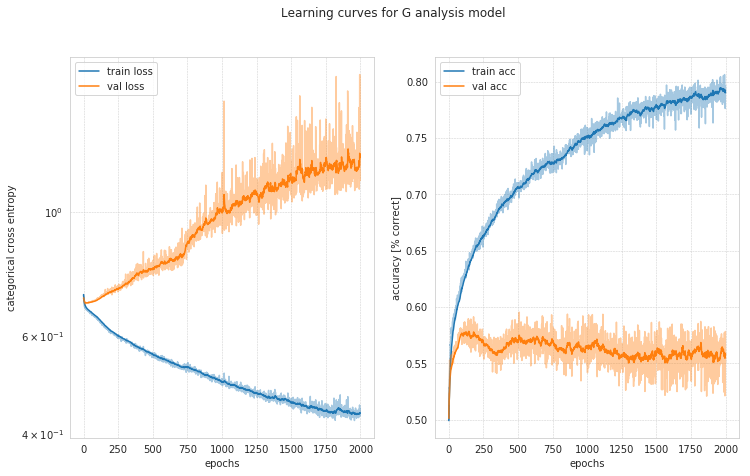

In [309]:
shadow_modelG = small_denseG(flattened_size)

crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)

loss_fun = nn.CrossEntropyLoss(g_shadow_target_weigths)
learning_rate = 0.05
epochs = 2000

mt = ModelTrainer(shadow_modelG, loss_fun, optim.SGD(shadow_modelG.parameters(), lr=learning_rate), y_hat_fun, crit_fun)
hist = mt.fit(g_shadow_train_dataset, g_shadow_test_dataset, epochs=epochs, batch_size=1000, verbose=epochs/20)
plotted = mt.plot_training("Learning curves for G analysis model")

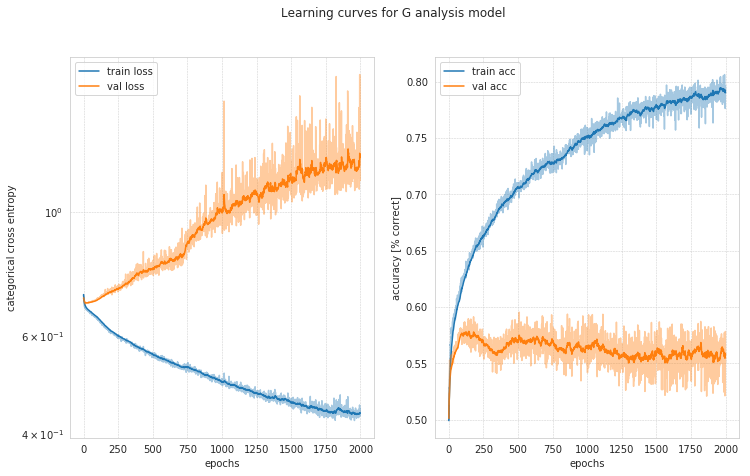

In [310]:
hist.plot("Learning curves for G analysis model")
plt.savefig("G_curve_" + sufix + ".png", dpi=300, bbox_inches='tight')

false negative percentage : 28.86345053147997
false positive percentage : 61.08786610878661


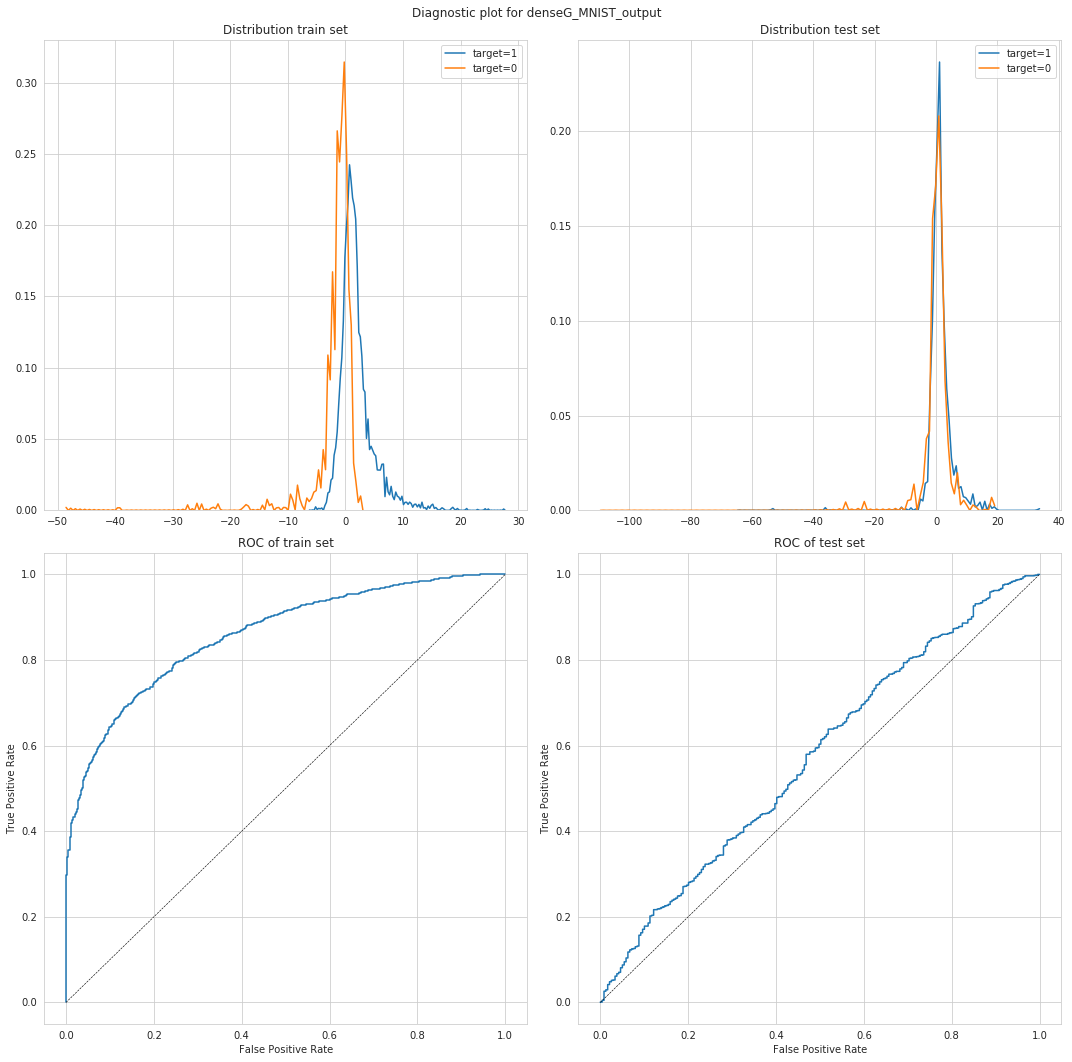


ROC score train : 0.8595526459356246
ROC score test : 0.5736237457106983


In [311]:
diagnostic_plots(shadow_modelG, [g_shadow_train_dataset], [g_shadow_test_dataset], bw=0.1, dataset_name=sufix,savefig=True)